In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from warnings import filterwarnings
filterwarnings('ignore')
from scipy.stats import skew, kurtosis, jarque_bera
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from tensorflow import keras

In [2]:
os.chdir('C:/Users/Joel/Desktop/Serie temporelle')

In [3]:
df = pd.read_csv('FINAL_USO.csv', index_col="Date", parse_dates = True)

### - [**Regression Linéaire Simple**](#Regression-Linéaire-Simple)
### - [**Regression Linéaire Multiple**](#Regression-Linéaire-Multiple)
### - [**Preprocessing**](#Preprocessing)

### Train et Test Set

In [9]:
trainset, testset = train_test_split(df, train_size=0.7, random_state=0)

In [5]:
trainset.shape

(1202, 80)

In [6]:
testset.shape

(516, 80)

In [10]:
X_train, y_train = trainset.drop('Adj Close', axis=1), trainset['Adj Close']

In [8]:
X_test, y_test = testset.drop('Adj Close', axis=1), testset['Adj Close']

In [9]:
y_train

Date
2017-03-16    116.730003
2014-06-02    119.699997
2015-07-23    104.330002
2018-10-23    116.389999
2014-09-25    117.389999
                 ...    
2015-06-15    113.730003
2016-12-22    107.589996
2018-09-26    113.050003
2014-05-05    126.220001
2014-11-04    112.220001
Name: Adj Close, Length: 1202, dtype: float64

### R Carré ajusté

In [23]:
def R2_Ajuste(r2,n,k):
    
    return r2-(k-1)/(n-k)*(1-r2)

In [12]:
Performance = pd.DataFrame({'Model': [],
                           'Details':[],
                           'Racine Carrée ECM':[],
                           'R2 (train)':[],
                           'R2 Ajusté (train)':[],
                           'R2 (test)':[],
                           'R2 Ajusté (test)':[],
                           '5-Fold Cross Validation':[],
                           'Prix moyen de l\'Or': []})

In [13]:
Performance

,Model,Details,Racine Carrée ECM,R2 (train),R2 Ajusté (train),R2 (test),R2 Ajusté (test),5-Fold Cross Validation,Prix moyen de l'Or


### Regression Linéaire Simple
- L'objet de cette section est de voir l'impact d'une seule variable sur la cible (Regression simple)
- Pour cette regression nous alons retenir la variable qui a la plus grande corrélation avec Cible
$$F_{\theta}(X)=\theta_{0}+\theta_{1}x$$

In [14]:
pd.set_option('display.max_rows', 80)
(df.corr()['Adj Close']).sort_values(ascending=False)

Close            1.000000
Adj Close        1.000000
High             0.999535
Low              0.999532
Open             0.998976
GDX_Low          0.975561
GDX_Close        0.975459
GDX_High         0.975255
GDX_Adj Close    0.974980
GDX_Open         0.974824
SF_Low           0.947842
SF_Price         0.947420
SF_Open          0.945557
SF_High          0.945203
EG_low           0.863917
EG_open          0.862900
EG_close         0.862770
EG_high          0.861479
EG_Ajclose       0.859850
PLT_Price        0.775861
PLT_High         0.775481
PLT_Low          0.773993
PLT_Open         0.773760
OF_High          0.711334
OF_Price         0.710693
OF_Open          0.709096
OF_Low           0.708266
SF_Volume        0.706505
USO_Adj Close    0.635675
USO_Close        0.635675
USO_High         0.635311
USO_Open         0.635197
USO_Low          0.634732
OS_High          0.632001
OS_Price         0.630817
OS_Open          0.630046
OS_Low           0.629083
EU_high          0.582969
EU_Price    

- Nous retenons la variables **Close et High** qui sont parfaitement corrélé avec la cible

In [16]:
model = LinearRegression()

#### 1. Adj Close et Close

In [18]:
X1_train = np.array(X_train['Close'], dtype=pd.Series).reshape(X_train.shape[0], 1)
y1_train = np.array(y_train, dtype=pd.Series)

X1_test = np.array(X_test['Close'], dtype=pd.Series).reshape(X_test.shape[0], 1)
y1_test = np.array(y_test, dtype=pd.Series)

model.fit(X1_train, y1_train)
y_pred = model.predict(X1_test)

RECM = np.sqrt(metrics.mean_squared_error(y1_test,y_pred))
R2_train = model.score(X1_train, y1_train)
R2_test = model.score(X1_test, y1_test)
cv = cross_val_score(model,trainset[['Close']],trainset['Adj Close'],cv=5).mean()

prix = y1_test.mean()
print('Ordonnée à l\'Origine: {}'.format(model.intercept_))
print('Pente: {}'.format(model.coef_))

r = Performance.shape[0]
Performance.loc[r] = ['Regression Linéaire simple Avec Close ','-',RECM, R2_train, '-',R2_test,'-',cv, prix]
Performance

Ordonnée à l'Origine: 0.0
Pente: [1.]


,Model,Details,Racine Carrée ECM,R2 (train),R2 Ajusté (train),R2 (test),R2 Ajusté (test),5-Fold Cross Validation,Prix moyen de l'Or
0,Regression Linéaire simple Avec Close,-,0.0,1.0,-,1.0,-,1.0,127.524903


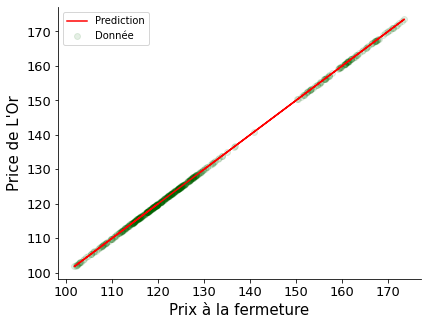

In [19]:
plt.figure(figsize=(6.5,5))
plt.scatter(X1_test,y1_test,color='darkgreen',label="Donnée", alpha=.1)
plt.plot(X1_test,model.predict(X1_test),color="red",label="Prediction")
plt.xlabel("Prix à la fermeture", fontsize=15)
plt.ylabel("Price de L'Or", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

- On constate que le modèle fait une erreur de 0%. Le modèle passe effectivement par tous les points

#### 2. Adj Close et High

In [20]:
X1_train = np.array(X_train['High'], dtype=pd.Series).reshape(X_train.shape[0], 1)
y1_train = np.array(y_train, dtype=pd.Series)

X1_test = np.array(X_test['High'], dtype=pd.Series).reshape(X_test.shape[0], 1)
y1_test = np.array(y_test, dtype=pd.Series)

RECM = np.sqrt(metrics.mean_squared_error(y1_test,y_pred))
R2_train = model.score(X1_train, y1_train)
R2_test = model.score(X1_test, y1_test)
cv = cross_val_score(model,trainset[['High']],trainset['Adj Close'],cv=5).mean()

prix = y1_test.mean()
print('Ordonnée à l\'Origine: {}'.format(model.intercept_))
print('Pente: {}'.format(model.coef_))

r = Performance.shape[0]
Performance.loc[r] = ['Regression Linéaire simple Avec High ','-',RECM, R2_train, '-',R2_test,'-',cv, prix]
Performance

Ordonnée à l'Origine: 0.0
Pente: [1.]


,Model,Details,Racine Carrée ECM,R2 (train),R2 Ajusté (train),R2 (test),R2 Ajusté (test),5-Fold Cross Validation,Prix moyen de l'Or
0,Regression Linéaire simple Avec Close,-,0.0,1.000000,-,1.000000,-,1.000000,127.524903
1,Regression Linéaire simple Avec High,-,0.0,0.998124,-,0.998065,-,0.999052,127.524903


### Adj Close et DJ_open

In [21]:
X1_train = np.array(X_train['DJ_open'], dtype=pd.Series).reshape(X_train.shape[0], 1)
y1_train = np.array(y_train, dtype=pd.Series)

X1_test = np.array(X_test['DJ_open'], dtype=pd.Series).reshape(X_test.shape[0], 1)
y1_test = np.array(y_test, dtype=pd.Series)

RECM = np.sqrt(metrics.mean_squared_error(y1_test,y_pred))
R2_train = model.score(X1_train, y1_train)
R2_test = model.score(X1_test, y1_test)
cv = cross_val_score(model,trainset[['DJ_open']],trainset['Adj Close'],cv=5).mean()

prix = y1_test.mean()
print('Ordonnée à l\'Origine: {}'.format(model.intercept_))
print('Pente: {}'.format(model.coef_))

r = Performance.shape[0]
Performance.loc[r] = ['Regression Linéaire simple Avec DJ_open','-',RECM, R2_train, '-',R2_test,'-',cv, prix]
Performance

Ordonnée à l'Origine: 0.0
Pente: [1.]


,Model,Details,Racine Carrée ECM,R2 (train),R2 Ajusté (train),R2 (test),R2 Ajusté (test),5-Fold Cross Validation,Prix moyen de l'Or
0,Regression Linéaire simple Avec Close,-,0.0,1.000000e+00,-,1.000000e+00,-,1.000000,127.524903
1,Regression Linéaire simple Avec High,-,0.0,9.981243e-01,-,9.980646e-01,-,0.999052,127.524903
2,Regression Linéaire simple Avec DJ_open,-,0.0,-1.133616e+06,-,-1.050653e+06,-,0.348782,127.524903


### Regression Linéaire Multiple
- L'objet de cette section est de voir l'impact de toutes les variable sur la cible (Regression simple)2

$$F_{\theta}(X)=\theta_{0}+\theta_{1}X1+\theta_{2}X2+....+\theta_{1}Xn$$

In [22]:
model.fit(X_train, y_train)

RECM = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
R2_train = model.score(X_train, y1_train)
R2_test = model.score(X_test, y1_test)
cv = cross_val_score(model,X_train,y_train,cv=5).mean()

prix = y_test.mean()
R_ajuste = R2_Ajuste(R2_train, trainset.shape[0], X_train.shape[1])
Rtest_ajuste = R2_Ajuste(R2_test, testset.shape[0], X_test.shape[1])
r = Performance.shape[0]
Performance.loc[r] = ['Regression Linéaire Multiple','Toutes les Variables',RECM, R2_train, R_ajuste ,R2_test, Rtest_ajuste,cv, prix]
Performance

,Model,Details,Racine Carrée ECM,R2 (train),R2 Ajusté (train),R2 (test),R2 Ajusté (test),5-Fold Cross Validation,Prix moyen de l'Or
0,Regression Linéaire simple Avec Close,-,0.0,1.000000e+00,-,1.000000e+00,-,1.000000,127.524903
1,Regression Linéaire simple Avec High,-,0.0,9.981243e-01,-,9.980646e-01,-,0.999052,127.524903
2,Regression Linéaire simple Avec DJ_open,-,0.0,-1.133616e+06,-,-1.050653e+06,-,0.348782,127.524903
3,Regression Linéaire Multiple,Toutes les Variables,0.0,1.000000e+00,1.0,1.000000e+00,1.0,1.000000,127.524903


#### Conclusion

- **Au terme de cette première approche de modélisation et de la matrice de corrélation (Analyse exploratoire Partie 1) entre toutes nos variables, nous retenons que plusieurs variables sont dépendantes. Ce faisant, une selection de variables sera très importante lors du prétraitement (OpenClassroom)**

- [Plus d'info](https://openclassrooms.com/fr/courses/4444646-entrainez-un-modele-predictif-lineaire/4444653-trouvez-une-combinaison-lineaire-de-variables-qui-approxime-leurs-etiquettes#/id/r-4521401)

# Preprocessing
- Selection de Variable;
- Normalisation
- Traitement de Valeur Aberrante

In [8]:
ACP = PCA(n_components=2)

In [13]:
ACP.fit_transform(X_train).shape

(1202, 2)

In [12]:
X_train

,Open,High,Low,Close,Volume,SP_open,SP_high,SP_low,SP_close,SP_Ajclose,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2017-03-16,117.269997,117.290001,116.690002,116.730003,9322000,239.110001,239.199997,238.100006,238.479996,229.571396,...,22.690001,22.770000,22.468874,61512900,10.390000,10.400000,10.290000,10.360000,10.360000,22429000
2014-06-02,119.930000,120.459999,119.610001,119.699997,5916100,192.949997,192.990005,191.970001,192.899994,175.472046,...,22.150000,22.290001,21.603308,21523400,37.520000,37.570000,37.380001,37.529999,37.529999,3111500
2015-07-23,104.980003,105.300003,104.199997,104.330002,5779300,211.529999,211.649994,209.750000,210.139999,195.847366,...,13.510000,13.620000,13.287169,69592000,16.440001,16.490000,16.020000,16.139999,16.139999,22692200
2018-10-23,117.160004,117.250000,116.330002,116.389999,12704200,270.950012,274.869995,268.609985,273.609985,272.021484,...,19.930000,20.100000,19.994211,51504500,14.360000,14.390000,13.930000,14.040000,14.040000,46733900
2014-09-25,116.300003,117.760002,116.199997,117.389999,7631700,199.039993,199.050003,196.270004,196.339996,180.295761,...,21.850000,22.350000,21.661459,35894800,35.080002,35.130001,34.650002,34.830002,34.830002,4266400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-15,113.279999,114.150002,113.209999,113.730003,5054000,208.639999,209.449997,207.789993,209.100006,193.934418,...,18.420000,18.590000,18.135717,28170400,19.950001,20.200001,19.940001,20.150000,20.150000,10051700
2016-12-22,107.680000,108.099998,107.489998,107.589996,4942800,225.600006,225.740005,224.919998,225.380005,216.960770,...,19.000000,19.070000,18.817804,59725500,11.500000,11.590000,11.460000,11.460000,11.460000,18279200
2018-09-26,113.110001,113.599998,112.660004,113.050003,8297300,290.910004,292.239990,289.410004,289.880005,288.197052,...,18.389999,18.420000,18.323053,78326300,15.170000,15.240000,15.090000,15.110000,15.110000,11065200


### Prediction avec Tensorflow/Deep Learning

#### Jeu de données d'entrainement et de validation

In [11]:
trainSet, Valset = train_test_split(trainset, train_size=0.7)

In [12]:
trainSet.shape

(841, 80)

In [13]:
Valset.shape

(361, 80)

In [24]:
X_train = trainSet.drop("Adj Close", axis=1)
y_train = trainSet['Adj Close']

X_val = Valset.drop("Adj Close", axis=1)
y_val = Valset['Adj Close']

In [17]:
X_test, y_test = testset.drop("Adj Close", axis=1), testset['Adj Close']

In [18]:
X_test.shape

(516, 79)

In [19]:
y_test.shape

(516,)

In [22]:
y_train.shape

(841,)

In [23]:
st = StandardScaler()

In [25]:
X_train_stand = st.fit_transform(X_train)
X_val_stand = st.transform(X_val)
X_test_stand = st.transform(X_test)

In [21]:
model = keras.models.Sequential()

In [29]:
model.add(keras.layers.Dense(10, activation = "relu", input_shape = X_train_stand.shape[1:]))
model.add(keras.layers.Dense(8, activation = "relu"))
model.add(keras.layers.Dense(5, activation = "relu"))
model.add(keras.layers.Dense(1))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 939
Trainable params: 939
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss="mse", optimizer = "rmsprop", metrics=["mae"])

In [32]:
model.fit(X_train_stand, y_train, epochs=10, validation_data=(X_val_stand, y_val))

Epoch 1/10
27/27 [==============================] - 2s 21ms/step - loss: 16637.1935 - mae: 127.7259 - val_loss: 16451.0879 - val_mae: 127.1054
Epoch 2/10
27/27 [==============================] - 0s 3ms/step - loss: 16598.9626 - mae: 127.6342 - val_loss: 16436.5859 - val_mae: 127.0485
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 16496.7085 - mae: 127.2957 - val_loss: 16403.5605 - val_mae: 126.9245
Epoch 4/10
27/27 [==============================] - 0s 3ms/step - loss: 16581.5530 - mae: 127.5809 - val_loss: 16313.4102 - val_mae: 126.5881
Epoch 5/10
27/27 [==============================] - 0s 2ms/step - loss: 16353.2829 - mae: 126.7358 - val_loss: 16161.5498 - val_mae: 126.0199
Epoch 6/10
27/27 [==============================] - 0s 2ms/step - loss: 16300.1921 - mae: 126.4870 - val_loss: 15923.0791 - val_mae: 125.1231
Epoch 7/10
27/27 [==============================] - 0s 2ms/step - loss: 16046.7429 - mae: 125.5470 - val_loss: 15562.9531 - val_mae: 123.7595
Epoch

In [34]:
model.evaluate(X_test_stand, y_test)

17/17 [==============================] - 0s 810us/step - loss: 13692.7275 - mae: 116.3337


[13692.7275390625, 116.33372497558594]

### Modélisation avec Linéaire avec Composantes principales

- Réduction du problème de multicolinéarité
- Réduction de dimension

In [12]:
st = StandardScaler()

In [5]:
trainset, testset = train_test_split(df, train_size=.7, random_state=0)

In [14]:
X_train, y_train = df.drop('Adj Close', axis=1), df['Adj Close']

X_test, y_test = df.drop('Adj Close', axis=1), df['Adj Close']

In [13]:
Xtrain = st.fit_transform(X_train)

In [15]:
X_test = st.transform(X_test)

In [8]:
pca = PCA(n_components=.95, random_state=0)

In [16]:
Xtrain = pca.fit_transform(Xtrain)

In [20]:
X_test = pca.transform(X_test)

In [17]:
Xtrain

array([[11.6975515 ,  2.3854512 ,  2.01878082, ..., -1.52440274,
         2.28913945,  1.94410638],
       [11.32498902,  2.11652925,  2.51349342, ..., -1.89836412,
        -0.15037332, -0.18604358],
       [11.09852099,  2.15924043,  1.93876704, ..., -1.38643682,
         0.16514338,  0.73199756],
       ...,
       [-7.64068428, -3.53959683,  2.89930254, ..., -1.45878172,
         1.64724164,  1.69604732],
       [-7.6008835 , -3.78482555,  2.81494226, ..., -1.44220074,
         1.96508773,  1.02528741],
       [-7.54487485, -2.9830491 ,  2.13815903, ..., -0.74813761,
         0.46493777, -0.27976301]])

In [18]:
linear = LinearRegression()

In [19]:
linear.fit(Xtrain, y_train)

LinearRegression()

In [21]:
linear.score(Xtrain, y_train)

0.9857538432126925

In [22]:
linear.score(X_test, y_test)

0.9857538432126925

In [24]:
linear.coef_

array([ 2.26327311e+00,  1.56928415e-01,  3.70134577e+00,  9.10608398e-02,
        9.41073216e-02, -1.39057904e-01,  3.42358995e-01, -8.10549970e-03,
        4.22428702e-02, -7.98407929e-02, -2.40665176e-01,  3.23483539e-03,
       -6.62735423e-01, -3.37632161e-02, -4.39942769e-01])

In [25]:
linear.intercept_

127.31948200349244

- Nous sommes dans un cas multivarié, de ce fait nous utiliseront une modélisation VAR et/ou GARCH

### Modélisation VAR et GARCH

1-Tester la stationnarité des données et le degré d'intégration

2-Détermination de la longueur du retard

3-Tester la causalité de Granger

4-Estimation du VAR

#### 1- Stationnarité

In [26]:
from statsmodels.tsa.stattools import adfuller

In [27]:
result = adfuller(df['Adj Close'])

In [28]:
result

(-1.8234601291067791,
 0.3688781538232949,
 1,
 1716,
 {'1%': -3.434166497101742,
  '5%': -2.8632257697922383,
  '10%': -2.5676674574279645},
 5546.384488385469)

In [44]:
def stationnarite(x):
    print('Augmented Dickey-Fuller test (DAF):' + '\n\n')
    
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    result = adfuller(x)
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("Preuves solides contre l'hypothèse nulle, rejette l'hypothèse nulle. Les données n'ont pas de racine unitaire et sont stationnaires")
    else:
        print("Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire ")
    print('====='*25)

In [45]:
df.aggregate(stationnarite)

Augmented Dickey-Fuller test (DAF):


ADF Test Statistic : -1.8463008423644895
p-value : 0.35772875583369057
#Lags Used : 0
Number of Observations Used : 1717
Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire 
Augmented Dickey-Fuller test (DAF):


ADF Test Statistic : -1.7801526424376242
p-value : 0.39035891836031456
#Lags Used : 0
Number of Observations Used : 1717
Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire 
Augmented Dickey-Fuller test (DAF):


ADF Test Statistic : -1.8089020844046253
p-value : 0.3760510982793307
#Lags Used : 2
Number of Observations Used : 1715
Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire 
Augmented Dickey-Fuller test (DAF):


ADF Test Statistic : -1.8234601291067791
p-value : 0.3688781538232949
#Lags Used : 1
Number of Observa

ADF Test Statistic : -1.864222408819324
p-value : 0.34907457901485606
#Lags Used : 0
Number of Observations Used : 1717
Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire 
Augmented Dickey-Fuller test (DAF):


ADF Test Statistic : -1.8235233496579035
p-value : 0.36884711487060695
#Lags Used : 0
Number of Observations Used : 1717
Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire 
Augmented Dickey-Fuller test (DAF):


ADF Test Statistic : -4.404808160821285
p-value : 0.0002910704180344951
#Lags Used : 24
Number of Observations Used : 1693
Preuves solides contre l'hypothèse nulle, rejette l'hypothèse nulle. Les données n'ont pas de racine unitaire et sont stationnaires
Augmented Dickey-Fuller test (DAF):


ADF Test Statistic : -1.3957101474826934
p-value : 0.5843309910002824
#Lags Used : 0
Number of Observations Used : 1717
Faible preuve 

ADF Test Statistic : -2.0346908713776677
p-value : 0.2715724842989583
#Lags Used : 6
Number of Observations Used : 1711
Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire 
Augmented Dickey-Fuller test (DAF):


ADF Test Statistic : -2.1124069703924144
p-value : 0.2395550510148623
#Lags Used : 11
Number of Observations Used : 1706
Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire 
Augmented Dickey-Fuller test (DAF):


ADF Test Statistic : -1.9091715134634824
p-value : 0.3277589185047467
#Lags Used : 1
Number of Observations Used : 1716
Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire 
Augmented Dickey-Fuller test (DAF):


ADF Test Statistic : -2.8290140363485987
p-value : 0.05424734686869529
#Lags Used : 23
Number of Observations Used : 1694
Faible preuve contr

ADF Test Statistic : -1.3122296612029172
p-value : 0.6235588214950413
#Lags Used : 1
Number of Observations Used : 1716
Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire 
Augmented Dickey-Fuller test (DAF):


ADF Test Statistic : -1.2928527333029833
p-value : 0.6324358201495837
#Lags Used : 2
Number of Observations Used : 1715
Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire 
Augmented Dickey-Fuller test (DAF):


ADF Test Statistic : -1.2239449934299171
p-value : 0.6632113056656422
#Lags Used : 9
Number of Observations Used : 1708
Faible preuve contre l'hypothèse nulle, la série temporelle a une racine unitaire, ce qui indique qu'elle est non stationnaire 
Augmented Dickey-Fuller test (DAF):


ADF Test Statistic : -3.6810202942181993
p-value : 0.004388180893132909
#Lags Used : 22
Number of Observations Used : 1695
Preuves solides con

Open             None
High             None
Low              None
Close            None
Adj Close        None
                 ... 
USO_High         None
USO_Low          None
USO_Close        None
USO_Adj Close    None
USO_Volume       None
Length: 80, dtype: object

- Au sens de Dickey-Fuller Augmenté, toutes les variables sont non stationnaires